# Introduction to resolution, pixels, and sampling
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

The resolution and pixel size are two quantities that both are important to determine how well small objects can be detected by an imaging system. They are often confused to be interchangable and in some cases even used in an incorrect way. In particular, commercial components like digital cameras and computer screens refer to resolution as the number of pixels of the device. 

Let's start with two definitions that will follow us in the next tutorials:
- __Resolution__ - measures the ability of an optical system to resolve two features in an observed scene. 
- __Pixel size__ - measures the distance between two adjacent pixels. This distance is also called the pixel pitch.

The pixel size should be smaller than the resolution in a well sampled image according to the [Nyquist-Shannon theorem](https://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem). 

The material in this notebook is not neutron specific and can be applied to any imaging system.

### What you will learn in this tutorial
- What is a pixel
- Pixel size 
- Sampling and spatial frequencies
- Resolution
- What can be resolved

### Needed mathematical concepts
- Convolution
- Image filtering
- Fourier transform

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf QuantifyingNeutronImages
    !git clone https://github.com/ImagingELearning/resolution.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/resolution/tutorials/00_common/data/"
    sys.path.append("/content/scripts/python")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

## Pixels
The pixel is the smallest item present in an image and it is mostly arranged in a rectilinear grid to form a matrix. The image size is given as the number of pixels in x and y. The field of view is real world dimensions of the image. The intensity of the pixel represents the number of quanta, e.g. neutrons or photons, hitting the active area of the pixel during the time of the exposure. 

The pixel size is not only important for measuring the dimensions of items in the image. It is also important for the intensity scaling of the reconstructed attenuation coefficients in computed tomography. Therefore, the pixel size must accurately measured when quantification based on the attenuation coefficient is foreseen. 

<figure>
<img src="figures/pixelgrid.svg" style="height:300px"/>
<figcaption><b>Figure 1</b> - A pixel grid with active areas.
</figure>
    
The pixel size defines how well an object can be described as you can see in the figure below. Where a circle with diameter 10mm is acquired using pixel sizes 0.1, 0.2, 0.5, 1, and 2 mm.

<figure>

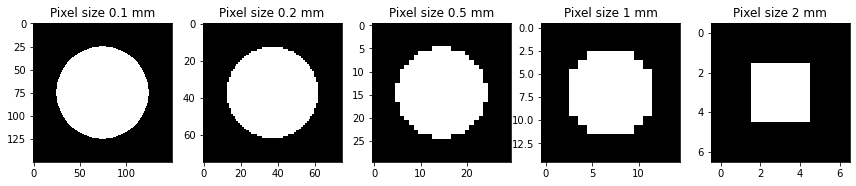

In [3]:
# This code is used to pruduce the images below. You not needed to understand
import numpy as np
import matplotlib.pyplot as plt

FOV = 15
R   = 5
pixel_sizes = [0.1, 0.2, 0.5, 1, 2]

fig,axes = plt.subplots(1,len(pixel_sizes),figsize=(12,25))
for ax,pixel_size in zip(axes,pixel_sizes) :
    xx=np.linspace(-FOV/2,FOV/2,int(np.floor(FOV/pixel_size)))
    x,y=np.meshgrid(xx,xx)
    disk = (x**2 + y**2)<R**2
    ax.imshow(disk,interpolation="none",cmap="gray")
    ax.set_title("Pixel size {0} mm".format(pixel_size))
    
plt.tight_layout()

<figcaption><b>Figure 2</b> - A filled circle with radius 5mm sampled with different pixel sizes.</figcaption>
</figure>

This observation brings us to the topic sampling.

## Sampling
Sampling is the process where the image on the scintillator is discretized which means that both intensity and positions are converted from the contiuous world into discrete steps.

<figure>
<img src="figures/grid.svg" style="height:300px"/>
<figcaption><b>Figure 3</b> - The world is continous but needs to be sampled into discrete structures for the computer.</figcaption>
</figure>
    
The sampling is done with a spatial freuqency which that corresponds to the pixel pitch. This means that higher frequencies can't be represented correctly. In this case we are talking about aliasing which appear as moiree fringes in images.

Ideally, according to the Nyquist-Shannon theorem, the sampling frequency should be at least twice the highest frequency in the object

$$f_s\leq2\cdot{}f_{image}$$

Explained in pixels this means that you need two pixels to describe a basic oscillation. Higher $f_s$ will allow to see more details in the image. 

### Exploring how different sampling frequencies affect the image
The following example demonstrates sampling effects on two example images. 
One with slanted line patterns and the other with concentric rings. The code block below creates the two images. You can play with different image sizes and ripple periods. Just don't make too small images otherwise the sampling may not work.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# create high resolved image as original "continuous"
N      = 2048
period = 64 # change this in the exercise below, don't forget to press shift-enter to update the images

omega  = N/(np.pi*period)
xx=np.linspace(-np.pi,np.pi,N)
x,y=np.meshgrid(xx,xx)

r=np.sqrt(x**2+y**2)
rings=np.sin(r*omega)
lines=np.sin((x+1.5*y)*omega)

<figure>

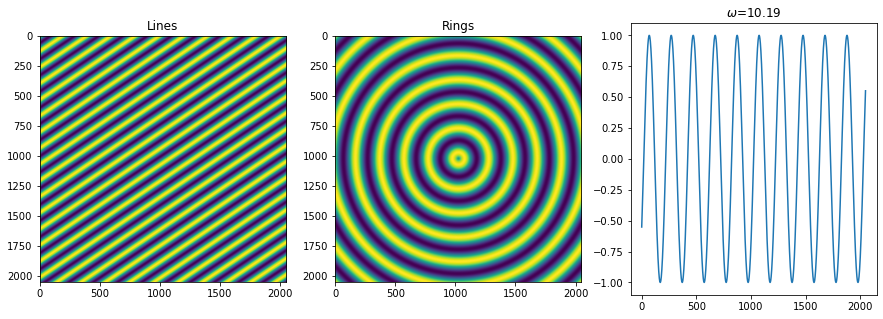

In [5]:
# displaying the created images
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(lines)
ax[0].set_title('Lines')
ax[1].imshow(rings)
ax[1].set_title('Rings');
yy=np.sin(xx*omega)
ax[2].plot(yy)
ax[2].set_title(r"$\omega$={0:0.2f}".format(omega));

<figcaption><b>Figure 4</b> - Line patterns of different shapes to be used in the following downsampling demonstration.</figcaption>
</figure>

This following function we use downsample the image and display the results. 

In [8]:
from skimage.transform import rescale, resize, downscale_local_mean
def show_sampling(img,period,binning=8) :
    '''
    The function displays the image before and after down sampling
    img - the image to explore
    binning - the pixels will be binned by this factor
    '''
    N=16
    crop=img[:binning*N,:binning*N]
    
    img_resized = resize(img, (img.shape[0] // binning, img.shape[1] // binning),
                       anti_aliasing=False)

    
    Ny,Nx=crop.shape
    
    fig,ax=plt.subplots(1,3,figsize=(15,5))
    
    ax[0].imshow(img)
    ax[0].set_title("Orignal image")
    ax[1].imshow(crop,cmap='gray')
    ax[1].set_xticks(np.linspace(0,Nx-1,Nx//binning))
    ax[1].set_xticklabels([])
    ax[1].set_yticks(np.linspace(0,Ny-1,Ny//binning))
    ax[1].set_yticklabels([])
    ax[1].grid(linewidth=1,color='red')
    ax[1].set_title('Magnified original image')


    ax[2].imshow(img_resized)
    ax[2].set_title("sampling ratio = {0:0.02f}".format(period/binning))

Test sampling function

<figure>

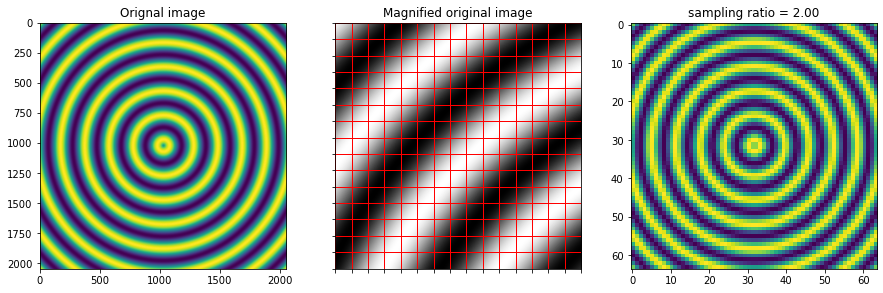

In [10]:
show_sampling(rings,binning=32,period=period)

<figcaption><b>Figure 5</b> - Testing the sampling function on the ring pattern. The grid in the mid panel shows the area covered by the pixels in the downsampled image.</figcaption>
</figure>

The original image here represents what the object really would look like and downsampled is what the detector can capture. The red grid lines in the magnified image show how large the new pixels are.

### Exercise - sampling
Use the ```show_sampling``` function to explore the relation between spatial frequencies in the scene and different sampling frequencies.

## Resolution
The pixel size and sampling theorem tell us the smallest items the detector is able to resolve. This is however only one component in the imaging system. The pixel size does not concern the optical components involved. These are the beam geometry (L/D), scintillators, and lenses. The combination of these components add some degree of blurring in the image. 

Let's first look at the resolution in a continuous context. We have two points to observe trough an imaging system. And depending on the sharpness of the optics these points will become smoother.

The smoothness is described by the so-called pointspread function. In the example below, we use a Gaussian filter kernel to simulate the blurring. The points are placed with ten pixels between them. 

<figure>

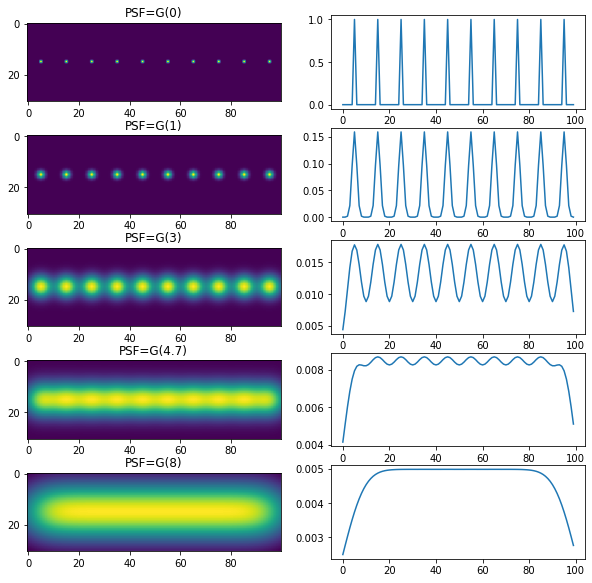

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian

img = np.zeros([31,100])
img[15,5::10]=1
fig,axes = plt.subplots(5,2,figsize=(10,10))
sigmas = [0,1,3,4.7,8]
for ax,s in zip(axes,sigmas) :
    g = gaussian(img,s)
    ax[0].imshow(g)
    ax[1].plot(g[15])
    ax[0].set_title(r"PSF=G({0})".format(s))

<figcaption><b>Figure 6</b> - The effect of different point spread functions using the same pixel size.</figcaption>
</figure>

Here, you can see that the blurring at some point is so strong that it is not possible to identify individual spots anymore.

Let's look at this observation in more detail using two dots.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

s=4.12
x=np.linspace(-25,25,201)
a=np.exp(-(x+5)**2/(2*s**2))
b=np.exp(-(x-5)**2/(2*s**2))

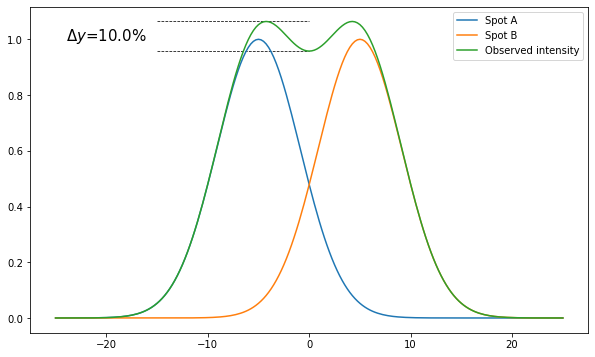

In [16]:
fig,ax = plt.subplots(1,figsize=(10,6))
ax.plot(x,a,label='Spot A')
ax.plot(x,b, label = 'Spot B')
ax.plot(x,a+b, label = 'Observed intensity')
ax.legend();
ymax = np.max(a+b)
ymin = np.min((a+b)[90:110])
ax.hlines([ymin,ymax],xmin=-15,xmax=0,color='black',linestyles='dashed',lw=0.75)
t = ax.text(-20, 0.5*(ymin+ymax), "$\Delta y$={0:0.1f}%".format(100*(ymax-ymin)/ymax), ha="center", va="center", size=15)

__Please note__! The smoothing introduced by the optical transfer function is mathematicall defined as a convolution same as some filters used to improve the signal to noise ratio. It does,  however, not affect the signal to noise ratio. I.e., you can't use optical components to improve the SNR. An exception is that a thicker scintillator capture more neutrons, this is a different effect though.

### Exercise - Point spread function
Use the example above to find a ratio between PSF width and distance between dots that still allows to distinguish the dots.

## Summary

In this tutorial we saw that
- Pixel size is _not_ the same as resolution
- The point spread function of the system defines the resolution
- The smallest features you can observe in an image depends on pixel size and resolution. 
- To large pixels will introduce moiree patterns due to a mismatch between greatest frequency in the observed pattern and the sampling frequency. 